In this notebook, we will attempt to visualize the SHMS dataset to gain a better understanding of it. Work on these tutorials has been supported in part by the Department of Energy Office of Nuclear Physics through EIC Detector R&D project eRD20.

# Background
The detectors, when assembled, look like this

<img src="img/shms_pdc_techdrawing.png" alt="SHMS Particle Tracker" style="width: 300px;"/>

There are two drift chambers (the big square holes in the green plates). The particles scattered from the beam pass through the two chambers, which detect their position. With two known points in 3D space, the particles' trajectories can be reconstructed. In each drift chamber, there are six wire planes. There are two with wires stretching horizontally (called X and X'), two with wires angled -60 degrees off the horizontal (called U and U'), and two with wires angled 60 degrees off the horizontal (called V and V'). The planes are numbered 1 through 12, with planes 1-6 corresponding to the first PDC and planes 7-12 corresponding to the second. Each plane contains about 100 wires spaced 1 cm apart.

| <img src="img/shms_pdc_xuplanes.png" alt="SHMS Wire Planes" style="width: 500px;"/> |
|:---:|
| *U/V plane (left), X plane (right)* |

# Initialization
We again begin by importing uproot and opening the data file.

In [1]:
import uproot

data = uproot.open('/volatile/hallc/comm2017/mkjones/ROOTfiles/shms_coin_replay_production_all_4019_100000.root')
tree = data['T']

# Set data prefix aliases
h = 'P.dc.hits.'
g = 'P.dc.gtrack.'

Because python does not provide any graphics capabilities in its core functionality, to do any visualization we will need the [pyplot](https://matplotlib.org/users/pyplot_tutorial.html) library.

In [2]:
import matplotlib.pyplot as plt  # this is the standard naming convention

In [3]:
%matplotlib notebook

That last cell is not python code; it is an IPython [magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html) that changes the behavior of pyplot to create interactive graphics objects instead of rendering a static png.

# Data Processing
As in the previous [notebook](SHMS%20Data%20Exploration.ipynb), we will want to combine the arrays for our filtered and unfiltered data. We'll also split up the hits in each track based on which PDC they belong to. To speed up subsequent calculations, we import the [numpy](http://www.numpy.org/) library which provides fast vector arithmetic.

In [10]:
import numpy as np
import lib.shms_helpers as shms

h_tracks = shms.collate(tree[h + 'plane'], tree[h + 'time'], tree[h + 'wirenum'])
g_tracks = shms.collate(tree[g + 'plane'], tree[g + 'time'], tree[g + 'wirenum'])

h_tracks_pdc1 = [np.asarray([hit for hit in track if hit[0] <= 6]) for track in h_tracks]
h_tracks_pdc2 = [np.asarray([hit for hit in track if hit[0] > 6]) for track in h_tracks]

g_tracks_pdc1 = [np.asarray([hit for hit in track if hit[0] <= 6]) for track in g_tracks]
g_tracks_pdc2 = [np.asarray([hit for hit in track if hit[0] > 6]) for track in g_tracks]

We'll use the `hit_to_2d()` method in the `shms_helpers` module to visualize the tracks. It takes in the attributes of a hit (plane, drift time, wire number) and outputs the endpoints of a line segment corresponding to the wire. It hides the messy details of the detector geometry so you don't have to deal with them. These points can then be passed into pyplot which will draw a line between them.

In [11]:
print(h_tracks[0], '\n')
print(h_tracks[0][0])
print(shms.hit_to_2d(h_tracks[0][0]))

[[  1.          46.28069215  53.        ]
 [  2.          55.35049315  53.        ]
 [  3.          17.71070515  30.        ]
 [  4.          75.81968615  29.        ]
 [  5.           6.76716115  45.        ]
 [  6.         130.98489815  44.        ]
 [  6.         146.03411215  45.        ]
 [  7.          58.13493215  50.        ]
 [  8.          59.89393315  51.        ]
 [  9.          58.94037715  25.        ]
 [ 10.          50.53994215  26.        ]
 [ 11.          41.28331215  43.        ]
 [ 12.          56.82827415  43.        ]] 

[ 1.         46.28069215 53.        ]
((24.407042731880104, -21.78097880328997), (-40.007, 39.993))


<IPython.core.display.Javascript object>


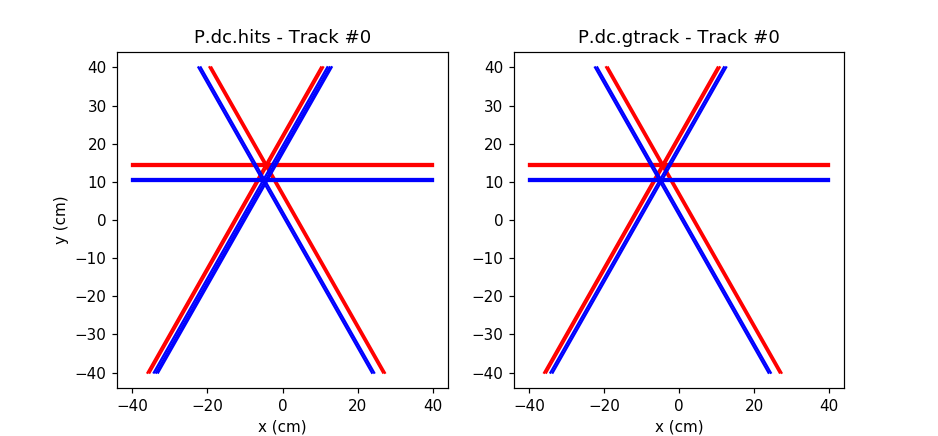

In [12]:
t = 0  # change this value to plot different tracks

fig_dim = 4  # size of figures
fig = plt.figure( figsize=(2.15 * fig_dim, fig_dim) )

ax1 = plt.subplot(1, 2, 1)  # y, x, subplot number
plt.title(h[:-1]  + ' - Track #' + str(t))
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
for hit in h_tracks_pdc2[t]:  # draw the second PDC first so that it appears in the background
    line = shms.hit_to_2d(hit)
    plt.plot(line[0], line[1], 'r')
for hit in h_tracks_pdc1[t]:
    line = shms.hit_to_2d(hit)
    plt.plot(line[0], line[1], 'b')

ax2 = plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # sharex/sharey make subplots pan/zoom together
plt.title(g[:-1]  + ' - Track #' + str(t))
plt.xlabel('x (cm)')
#plt.ylabel('y (cm)')
for hit in g_tracks_pdc2[t]:
    line = shms.hit_to_2d(hit)
    plt.plot(line[0], line[1], 'r')
for hit in g_tracks_pdc1[t]:
    line = shms.hit_to_2d(hit)
    plt.plot(line[0], line[1], 'b')

plt.show()

We can also visualize the individual tracks in 3D using `hit_to_3d()`. For this, we abuse pyplot's `quiver()` method (which is meant for plotting vector fields) to draw a collection of 3D lines.

<IPython.core.display.Javascript object>


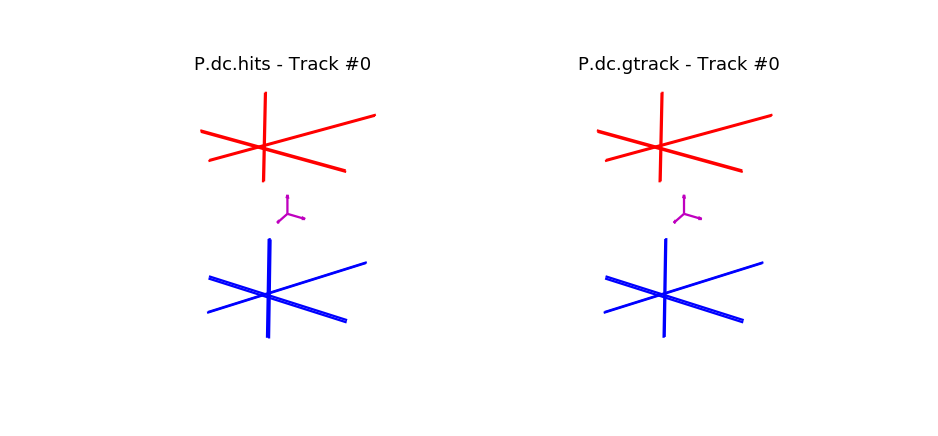

In [17]:
# We need an extra import to enable 3D plotting
from mpl_toolkits.mplot3d import Axes3D

t = 0  # change this value to plot different tracks
show_axes = False


fig_dim = 4
fig = plt.figure( figsize=(2.15*fig_dim, fig_dim) )

ax1 = fig.add_subplot(121, projection='3d')
plt.title(h[:-1] + ' - Track #' + str(t))
ax1.set_xlabel('$X$ (cm)')
ax1.set_ylabel('$-Y$ (cm)')
ax1.set_zlabel('$Z$ (cm)')
ax1.set_axis_on() if show_axes else ax1.set_axis_off()

# Plot PDC 1 wire hits
for hit in h_tracks_pdc1[t]:
    wire = shms.hit_to_3d(hit)
    x, y, z = wire[0]
    u, v, w = wire[1]
    ax1.quiver(x,y,z, u,v,w, color='b', arrow_length_ratio=0.0)
    # Add small vectors at tips of existing ones to make Matplotlib scale the plotting volume correctly
    x, y, z = (i+j for (i,j) in zip(wire[0], wire[1]))
    u, v, w = (0.001, 0.001, 0.001)
    ax1.quiver(x,y,z, u,v,w, color='b', arrow_length_ratio=0.0)

# Plot PDC 2 wire hits
for hit in h_tracks_pdc2[t]:
    wire = shms.hit_to_3d(hit)
    x, y, z = wire[0]
    u, v, w = wire[1]
    ax1.quiver(x,y,z, u,v,w, color='r', arrow_length_ratio=0.0)
    # Add small vectors at tips of existing ones to make Matplotlib scale the plotting volume correctly
    x, y, z = (i+j for (i,j) in zip(wire[0], wire[1]))
    u, v, w = (0.001, 0.001, 0.001)
    ax1.quiver(x,y,z, u,v,w, color='r', arrow_length_ratio=0.0)

# Show coordinate system
# Last entries in x,...,w arrays create small vector so Matplotlib scales volume correctly
x = [0, 0, 0, 0]
y = [0, 0, 0, 0]
z = [0, 0, 0, 10]
u = [10, 0, 0, 0.001]
v = [0, -10, 0, 0.001]
w = [0, 0, 10, 0.001]
ax1.quiver(x,y,z, u,v,w, color='m', arrow_length_ratio=0.2)


ax2 = fig.add_subplot(122, projection='3d')
plt.title(g[:-1] + ' - Track #' + str(t))
ax2.set_xlabel('$X$ (cm)')
ax2.set_ylabel('$-Y$ (cm)')
ax2.set_zlabel('$Z$ (cm)')
ax2.set_axis_on() if show_axes else ax2.set_axis_off()

# Plot PDC 1 wire hits
for hit in g_tracks_pdc1[t]:
    wire = shms.hit_to_3d(hit)
    x, y, z = wire[0]
    u, v, w = wire[1]
    ax2.quiver(x,y,z, u,v,w, color='b', arrow_length_ratio=0.0)
    # Add small vectors at tips of existing ones to make Matplotlib scale the plotting volume correctly
    x, y, z = (i+j for (i,j) in zip(wire[0], wire[1]))
    u, v, w = (0.001, 0.001, 0.001)
    ax2.quiver(x,y,z, u,v,w, color='b', arrow_length_ratio=0.0)

# Plot PDC 2 wire hits
for hit in g_tracks_pdc2[t]:
    wire = shms.hit_to_3d(hit)
    x, y, z = wire[0]
    u, v, w = wire[1]
    ax2.quiver(x,y,z, u,v,w, color='r', arrow_length_ratio=0.0)
    # Add small vectors at tips of existing ones to make Matplotlib scale the plotting volume correctly
    x, y, z = (i+j for (i,j) in zip(wire[0], wire[1]))
    u, v, w = (0.001, 0.001, 0.001)
    ax2.quiver(x,y,z, u,v,w, color='r', arrow_length_ratio=0.0)

# Show coordinate system
# Last entries in x,...,w arrays create small vector so Matplotlib scales volume correctly
x = [0, 0, 0, 0]
y = [0, 0, 0, 0]
z = [0, 0, 0, 10]
u = [10, 0, 0, 0.001]
v = [0, -10, 0, 0.001]
w = [0, 0, 10, 0.001]
ax2.quiver(x,y,z, u,v,w, color='m', arrow_length_ratio=0.2)


plt.show()

# More data visualization ideas
There are many possible correlations and distributions you should investigate. The point is to truly understand the data so that you can later apply the correct machine learning techniques. Here are just a few ideas:

### Hit count relationships

<IPython.core.display.Javascript object>


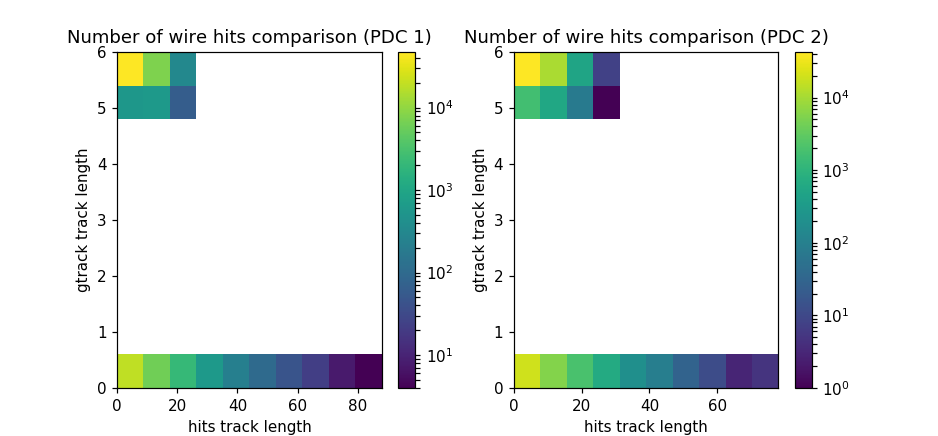

In [14]:
from matplotlib.colors import LogNorm  # logarithmic color scale

fig_dim = 4
fig = plt.figure( figsize=(2.15*fig_dim, fig_dim) )

plt.subplot(121)
plt.hist2d([len(track) for track in h_tracks_pdc1],
           [len(track) for track in g_tracks_pdc1], bins=10, norm=LogNorm())
plt.title('Number of wire hits comparison (PDC 1)')
plt.xlabel('hits track length')
plt.ylabel('gtrack track length')
plt.colorbar()

plt.subplot(122)
plt.hist2d([len(track) for track in h_tracks_pdc2],
           [len(track) for track in g_tracks_pdc2], bins=10, norm=LogNorm())
plt.title('Number of wire hits comparison (PDC 2)')
plt.xlabel('hits track length')
plt.ylabel('gtrack track length')
plt.colorbar()

plt.show()

### Distribution of drift times

<IPython.core.display.Javascript object>


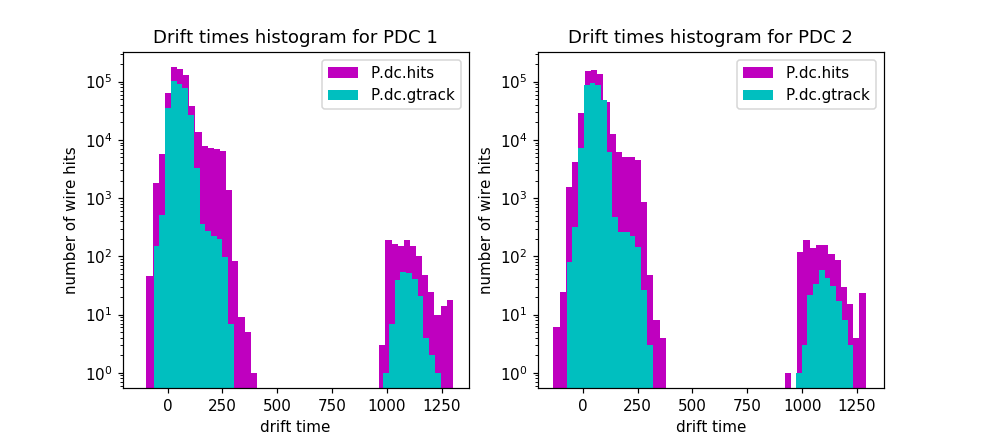

In [15]:
fig_dim = 4
fig = plt.figure( figsize=(2.25*fig_dim, fig_dim) )

ax1 = plt.subplot(121)
plt.hist([hit[1] for track in h_tracks_pdc1 for hit in track], bins=50, log=True, color='m', label=h[:-1])
plt.hist([hit[1] for track in g_tracks_pdc1 for hit in track], bins=50, log=True, color='c', label=g[:-1])
plt.title('Drift times histogram for PDC 1')
plt.xlabel('drift time')
plt.ylabel('number of wire hits')
plt.legend()

ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
plt.hist([hit[1] for track in h_tracks_pdc2 for hit in track], bins=50, log=True, color='m', label=h[:-1])
plt.hist([hit[1] for track in g_tracks_pdc2 for hit in track], bins=50, log=True, color='c', label=g[:-1])
plt.title('Drift times histogram for PDC 2')
plt.xlabel('drift time')
plt.ylabel('number of wire hits')
plt.legend()

plt.show()

### Hit count distributions for each wire chamber

<IPython.core.display.Javascript object>


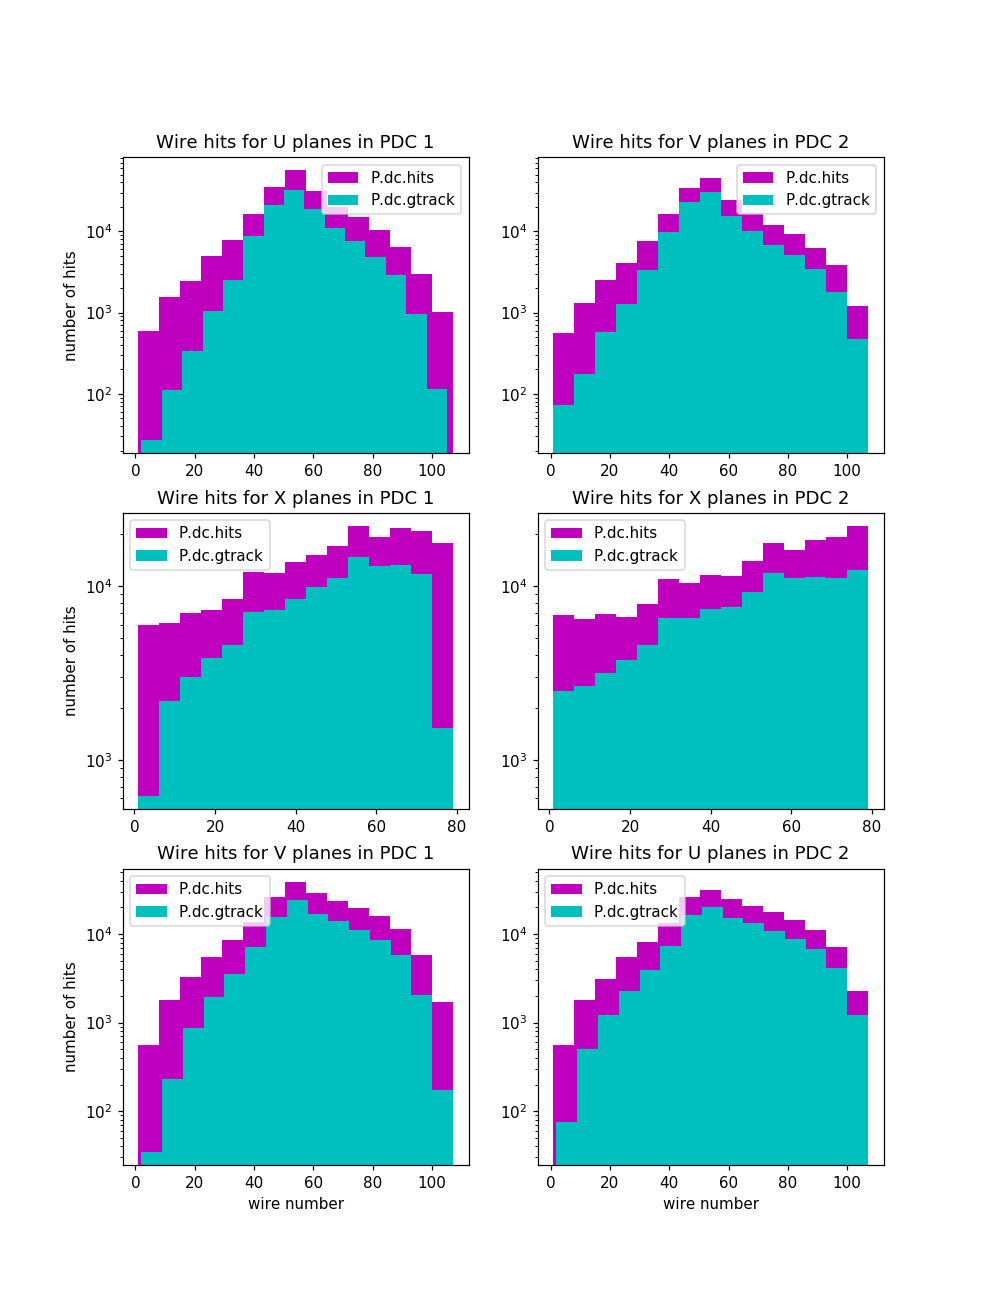

In [19]:
log = False  # use log scale on y-axis
fig_dim = 4
fig = plt.figure( figsize=(2.25*fig_dim, 3*fig_dim) )

num_bins = 15

ax1 = plt.subplot(321)
plt.hist([hit[2] for track in h_tracks_pdc1 for hit in track if hit[0] < 3],
         bins=num_bins, log=log, color='m', label=h[:-1])
plt.hist([hit[2] for track in g_tracks_pdc1 for hit in track if hit[0] < 3],
         bins=num_bins, log=log, color='c', label=g[:-1])
plt.title('Wire hits for U planes in PDC 1')
#plt.xlabel('wire number')
plt.ylabel('number of hits')
plt.legend()

ax2 = plt.subplot(322, sharex=ax1, sharey=ax1)
plt.hist([hit[2] for track in h_tracks_pdc2 for hit in track if hit[0] > 6 and hit[0] < 9],
         bins=num_bins, log=log, color='m', label=h[:-1])
plt.hist([hit[2] for track in g_tracks_pdc2 for hit in track if hit[0] > 6 and hit[0] < 9],
         bins=num_bins, log=log, color='c', label=g[:-1])
plt.title('Wire hits for V planes in PDC 2')
#plt.xlabel('wire number')
#plt.ylabel('number of hits')
plt.legend()


ax3 = plt.subplot(323)
plt.hist([hit[2] for track in h_tracks_pdc1 for hit in track if hit[0] > 2 and hit[0] < 5],
         bins=num_bins, log=log, color='m', label=h[:-1])
plt.hist([hit[2] for track in g_tracks_pdc1 for hit in track if hit[0] > 2 and hit[0] < 5],
         bins=num_bins, log=log, color='c', label=g[:-1])
plt.title('Wire hits for X planes in PDC 1')
#plt.xlabel('wire number')
plt.ylabel('number of hits')
plt.legend()

ax4 = plt.subplot(324, sharex=ax3, sharey=ax3)
plt.hist([hit[2] for track in h_tracks_pdc2 for hit in track if hit[0] > 8 and hit[0] < 11],
         bins=num_bins, log=log, color='m', label=h[:-1])
plt.hist([hit[2] for track in g_tracks_pdc2 for hit in track if hit[0] > 8 and hit[0] < 11],
         bins=num_bins, log=log, color='c', label=g[:-1])
plt.title('Wire hits for X planes in PDC 2')
#plt.xlabel('wire number')
#plt.ylabel('number of hits')
plt.legend()


ax5 = plt.subplot(325)
plt.hist([hit[2] for track in h_tracks_pdc1 for hit in track if hit[0] > 4 and hit[0] < 7],
         bins=num_bins, log=log, color='m', label=h[:-1])
plt.hist([hit[2] for track in g_tracks_pdc1 for hit in track if hit[0] > 4 and hit[0] < 7],
         bins=num_bins, log=log, color='c', label=g[:-1])
plt.title('Wire hits for V planes in PDC 1')
plt.xlabel('wire number')
plt.ylabel('number of hits')
plt.legend()

ax6 = plt.subplot(326, sharex=ax5, sharey=ax5)
plt.hist([hit[2] for track in h_tracks_pdc2 for hit in track if hit[0] > 10],
         bins=num_bins, log=log, color='m', label=h[:-1])
plt.hist([hit[2] for track in g_tracks_pdc2 for hit in track if hit[0] > 10],
         bins=num_bins, log=log, color='c', label=g[:-1])
plt.title('Wire hits for U planes in PDC 2')
plt.xlabel('wire number')
#plt.ylabel('number of hits')
plt.legend()

plt.show()

Once you feel comfortable with the SHMS dataset (but not before), you should move on to the next [notebook]().